# **Features Engineering and Implication of SAKT+LightGBM** 
1. Features engineering uncovers many hidden facts that are significant to trace any user.
2. The self attention knowledge tracing model with feed forward neural network tracks user behavior using the context of interactions.
3. Multiple heads in self attention knowledge tracing model, for tracing user knowledge level, gives advantage of parallel multiple executions to improve prediction efficiently. 
4. Use of LightGBM package is its fast-speed, high-efficiency, and low memory usage.


In [1]:
!pip install ../input/python-datatable/datatable-0.11.0-cp37-cp37m-manylinux2010_x86_64.whl > /dev/null 2>&1

In [2]:
# Import packages
import numpy as np 
import pandas as pd 
import psutil
from collections import defaultdict
import datatable as dt
import lightgbm as lgb
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
import gc
import pickle

_ = np.seterr(divide='ignore', invalid='ignore')

# **Pre-processing**

In [3]:
data_types_dict = {
    'timestamp': 'int64',
    'user_id': 'int32', 
    'content_id': 'int16', 
    'content_type_id':'int8', 
    'task_container_id': 'int16',
    'answered_correctly': 'int8', 
    'prior_question_elapsed_time': 'float32', 
    'prior_question_had_explanation': 'bool'
}
target = 'answered_correctly'
train_df = dt.fread('Riiid Answer Correctness/train.csv', columns=set(data_types_dict.keys())).to_pandas()
print(psutil.virtual_memory().percent)
gc.collect()


15.8


0

In [4]:
# Get dataframe of lectures.csv
lectures_df = pd.read_csv('Riiid Answer Correctness/lectures.csv')
print(lectures_df)
# Replace "solving question" value in type_of column with "solving_question"
lectures_df['type_of'] = lectures_df['type_of'].replace('solving question', 'solving_question')
# Get dummies of two columns (part, type_of) in lectures_df
lectures_df = pd.get_dummies(lectures_df, columns=['part', 'type_of'])
lectures_top_categories = [column for column in lectures_df.columns if column.startswith('part')]
lectures_basic_purposes = [column for column in lectures_df.columns if column.startswith('type_of_')]
print(lectures_df)
# Merge train_df with lectures_df where content_id is lecture_id
train_df_with_lectures = train_df[train_df.content_type_id == True].merge(lectures_df, left_on='content_id', right_on='lecture_id', how='left')
print(train_df_with_lectures)
# For each user, get total lecture interactions for each part and each type
user_lecture_interactions = train_df_with_lectures.groupby('user_id',as_index = False)[lectures_top_categories + lectures_basic_purposes].sum()
print(user_lecture_interactions)

     lecture_id  tag  part           type_of
0            89  159     5           concept
1           100   70     1           concept
2           185   45     6           concept
3           192   79     5  solving question
4           317  156     5  solving question
..          ...  ...   ...               ...
413       32535    8     5  solving question
414       32570  113     3  solving question
415       32604   24     6           concept
416       32625  142     2           concept
417       32736   82     3           concept

[418 rows x 4 columns]
     lecture_id  tag  part_1  part_2  part_3  part_4  part_5  part_6  part_7  \
0            89  159       0       0       0       0       1       0       0   
1           100   70       1       0       0       0       0       0       0   
2           185   45       0       0       0       0       0       1       0   
3           192   79       0       0       0       0       1       0       0   
4           317  156       0       0

In [5]:
# Specify datatypes of all newly added columns in lectures_df
lecturedata_types_dict = {   
    'user_id': 'int32', 
    'part_1': 'int8',
    'part_2': 'int8',
    'part_3': 'int8',
    'part_4': 'int8',
    'part_5': 'int8',
    'part_6': 'int8',
    'part_7': 'int8',
    'type_of_concept': 'int8',
    'type_of_intention': 'int8',
    'type_of_solving_question': 'int8',
    'type_of_starter': 'int8'
}
user_lecture_interactions = user_lecture_interactions.astype(lecturedata_types_dict)
for column in user_lecture_interactions.columns:
    if(column !='user_id'):
        user_lecture_interactions[column] = (user_lecture_interactions[column] > 0).astype('int8')
print(user_lecture_interactions.dtypes)
del(train_df_with_lectures)
gc.collect()

user_id                     int32
part_1                       int8
part_2                       int8
part_3                       int8
part_4                       int8
part_5                       int8
part_6                       int8
part_7                       int8
type_of_concept              int8
type_of_intention            int8
type_of_solving_question     int8
type_of_starter              int8
dtype: object


22

In [6]:
# Calculate user interactions count and pattern of lecture interactions along the records of each user
cum = train_df.groupby('user_id')['content_type_id'].agg(['cumsum', 'cumcount'])
train_df['cumulative_user_lectures'] = cum['cumsum'] 
train_df['user_lecture_interaction_pattern'] = cum['cumsum'] / cum['cumcount']
train_df.user_lecture_interaction_pattern=train_df.user_lecture_interaction_pattern.astype('float16')
train_df.cumulative_user_lectures=train_df.cumulative_user_lectures.astype('int8')
print(train_df['cumulative_user_lectures'].head(n=50))
print(train_df['user_lecture_interaction_pattern'].head(n=50))

# Calculate user interactions count and total lecture interactions for each user
user_lecture_aggregate = train_df.groupby('user_id')['content_type_id'].agg(['sum', 'count'])
print(user_lecture_aggregate)

# Specify datatypes of columns in train_df
data_types_dict = {
    'timestamp': 'int64',
    'user_id': 'int32', 
    'content_id': 'int16', 
    'content_type_id':'int8', 
    'task_container_id': 'int16',
    'answered_correctly': 'int8', 
    'prior_question_elapsed_time': 'float32', 
    'prior_question_had_explanation': 'bool'
}
target = 'answered_correctly'
# Fill NAN places in "prior_question_had_explanation" column with False
train_df['prior_question_had_explanation'].fillna(False, inplace=True)
del cum
gc.collect()
# Set specified datatypes to columns in train_df
train_df = train_df.astype(data_types_dict)

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    0
43    0
44    0
45    0
46    0
47    0
48    0
49    0
Name: cumulative_user_lectures, dtype: int8
0     NaN
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
25    0.0
26    0.0
27    0.0
28    0.0
29    0.0
30    0.0
31    0.0
32    0.0
33    0.0
34    0.0
35    0.0
36    0.0
37    0.0
38    0.0
39    0.0
40    0.0
41    0.0
42    0.0
43    0.0
44    0.0
45    0.0
46    NaN
47    0.0
48    0.0
49    0.0
Name: user_lecture_interaction_pattern, dtype: float16
 

In [7]:
# Get all records of train_df in which interactions are questions
train_df = train_df[train_df[target] != -1].reset_index(drop=True)
print(train_df)
# Fill NAN places in "prior_question_elapsed_time" column with its mean value
prior_question_elapsed_time_mean=train_df['prior_question_elapsed_time'].mean()
train_df['prior_question_elapsed_time'].fillna(prior_question_elapsed_time_mean, inplace=True)
print(train_df['prior_question_elapsed_time'])
# Get maximum timestamp for each user
max_timestamp_u = train_df[['user_id','timestamp']].groupby(['user_id']).agg(['max']).reset_index()
max_timestamp_u.columns = ['user_id', 'max_time_stamp']
# Get actualtimestamp of interaction by subtracting previous time from the current timestamp
train_df['actualtimestamp'] = train_df.groupby('user_id')['timestamp'].shift()
train_df['actualtimestamp']=train_df['timestamp']-train_df['actualtimestamp']
train_df['actualtimestamp'].fillna(0, inplace=True)
train_df.actualtimestamp=train_df.actualtimestamp.astype('int32')
print(train_df.actualtimestamp)
# Get average of actualtimestamp for each user
actualtimestamp_calc = train_df.groupby('user_id')['actualtimestamp'].agg(['mean'])
train_df['actualtimestamp_avg'] = train_df['user_id'].map(actualtimestamp_calc['mean'])
train_df.actualtimestamp_avg=train_df.actualtimestamp_avg.astype('int32')
print(train_df.actualtimestamp_avg)
# Get "actual_prior_question_elapsed_time" by subtracting previous time from "prior_question_elapsed_time" of current interaction 
user_prior_question_elapsed_time = train_df[['user_id','prior_question_elapsed_time']].groupby(['user_id']).tail(1)
user_prior_question_elapsed_time.columns = ['user_id', 'prior_question_elapsed_time']
train_df['actual_prior_question_elapsed_time'] = train_df.groupby('user_id')['prior_question_elapsed_time'].shift()
train_df['actual_prior_question_elapsed_time'] = train_df['prior_question_elapsed_time']-train_df['actual_prior_question_elapsed_time']
train_df['actual_prior_question_elapsed_time'].fillna(0, inplace=True)
train_df.actual_prior_question_elapsed_time=train_df.actual_prior_question_elapsed_time.astype('int32')
print(train_df.actual_prior_question_elapsed_time)
# Convert miliseconds of timestamp into seconds
train_df['timestamp']=train_df['timestamp']/(1000*3600)
train_df.timestamp=train_df.timestamp.astype('int16')
print(train_df.timestamp)

          timestamp     user_id  content_id  content_type_id  \
0                 0         115        5692                0   
1             56943         115        5716                0   
2            118363         115         128                0   
3            131167         115        7860                0   
4            137965         115        7922                0   
...             ...         ...         ...              ...   
99271295  428564420  2147482888        3586                0   
99271296  428585000  2147482888        6341                0   
99271297  428613475  2147482888        4212                0   
99271298  428649406  2147482888        6343                0   
99271299  428692118  2147482888        7995                0   

          task_container_id  answered_correctly  prior_question_elapsed_time  \
0                         1                   1                          NaN   
1                         2                   1                      37

In [8]:
# Get correctness trend along the records of each user
train_df['lag'] = train_df.groupby('user_id')[target].shift()
marks_trend = train_df.groupby('user_id')['lag'].agg(['cumsum', 'cumcount'])
train_df['user_correctness'] = marks_trend['cumsum'] / marks_trend['cumcount']
train_df.user_correctness=train_df.user_correctness.astype('float16')
print(train_df.user_correctness)
# Get comulative score of questions attempted along the records of each user
train_df['user_cumulative_score'] = marks_trend['cumsum']
train_df['user_cumulative_score'].fillna(0, inplace=True)
train_df.user_cumulative_score=train_df.user_cumulative_score.astype('int16')
print(train_df.user_cumulative_score.head(n=50))
# Get cumulative count of questions attempted along the records of each user
train_df['user_cumulative_questions_count'] = marks_trend['cumcount']
train_df.user_cumulative_questions_count=train_df.user_cumulative_questions_count.astype('int16')
print(train_df.user_cumulative_questions_count.head(n=50))
train_df.drop(columns=['lag'], inplace=True)
# Get average count of prior explored questions for each user_id
train_df.prior_question_had_explanation=train_df.prior_question_had_explanation.astype('int8')
train_df['lag'] = train_df.groupby('user_id')['prior_question_had_explanation'].shift()
exploration_trend = train_df.groupby('user_id')['lag'].agg(['cumsum', 'cumcount'])
train_df['avg_prior_exploration'] = exploration_trend['cumsum'] / exploration_trend['cumcount']
train_df['avg_prior_exploration'].fillna(0, inplace=True)
train_df.avg_prior_exploration=train_df.avg_prior_exploration.astype('float16')
print(train_df.avg_prior_exploration)
# Get count of prior explored questions along the records of each user
train_df['cumulative_exploration_count'] = exploration_trend['cumsum']
train_df['cumulative_exploration_count'].fillna(0, inplace=True)
train_df.cumulative_exploration_count=train_df.cumulative_exploration_count.astype('int16')
print(train_df.cumulative_exploration_count)

train_df.drop(columns=['lag'], inplace=True)
del marks_trend
del exploration_trend
gc.collect()

0                NaN
1           1.000000
2           1.000000
3           1.000000
4           1.000000
              ...   
99271295    0.500000
99271296    0.521973
99271297    0.541504
99271298    0.560059
99271299    0.538574
Name: user_correctness, Length: 99271300, dtype: float16
0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
11    10
12    10
13    10
14    11
15    12
16    13
17    14
18    14
19    15
20    16
21    16
22    16
23    16
24    16
25    17
26    18
27    19
28    20
29    21
30    21
31    22
32    22
33    23
34    24
35    25
36    26
37    26
38    27
39    28
40    29
41    30
42    31
43    31
44    31
45    31
46     0
47     1
48     1
49     2
Name: user_cumulative_score, dtype: int16
0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
11    11
12    12
13    13
14    14
15    15
16    16
17    17
18    18
19    19
20    20
21    21
22    22
23    23
24  

0

In [9]:
# Get trend of attempts count for each interaction along the records of each user
train_df["attempt_no"] = 1
train_df.attempt_no=train_df.attempt_no.astype('int8')
train_df["attempt_no"] = train_df[["user_id","content_id",'attempt_no']].groupby(["user_id","content_id"])["attempt_no"].cumsum()
print(train_df["attempt_no"])
# Get total attempts of each interaction for each user
interaction_total_attempts_calc=train_df.groupby(["user_id","content_id"])["attempt_no"].agg(['sum'])
interaction_total_attempts_calc=interaction_total_attempts_calc.astype('int8')
print(interaction_total_attempts_calc)
# Get count of exploring answers (sum) for each user
answer_explored_calc = train_df.groupby('user_id')['prior_question_had_explanation'].agg(['sum', 'count'])
answer_explored_calc=answer_explored_calc.astype('int16')
print(answer_explored_calc)
# Get total marks (sum) and total interactions (count) for each user
user_level_calc = train_df.groupby('user_id')[target].agg(['sum', 'count'])
user_level_calc=user_level_calc.astype('int16')
print(user_level_calc)
# Get total marks (sum), total interactions (count) and marks variance (var) for each question_id
question_level_calc = train_df.groupby('content_id')[target].agg(['sum', 'count','var'])
question_level_calc = question_level_calc.astype('float32')
print(question_level_calc)
# Get question level of easiness by dividing total score with total interactions
train_df['question_interactions'] = train_df['content_id'].map(question_level_calc['count']).astype('int32')
train_df['question_score'] = train_df['content_id'].map(question_level_calc['sum']).astype('int32')
train_df['question_easiness'] = train_df['content_id'].map(question_level_calc['sum'] / question_level_calc['count'])
train_df.question_easiness=train_df.question_easiness.astype('float16')
print(train_df.question_easiness)
# Get total marks (sum), total interactions (count), and marks variance (var) for each batch of questions that consecutively attempt before exploring answers
questions_batch_calc = train_df.groupby('task_container_id')[target].agg(['sum', 'count','var'])
questions_batch_calc=questions_batch_calc.astype('float32')
print(questions_batch_calc)
# Get easiness level of each batch of questions by dividing total score with total interactions
train_df['questions_batch_score'] = train_df['task_container_id'].map(questions_batch_calc['sum']).astype('int32')
train_df['questions_batch_score_variance'] = train_df['task_container_id'].map(questions_batch_calc['var']).astype('float16')
train_df['questions_batch_easiness'] = train_df['task_container_id'].map(questions_batch_calc['sum'] / questions_batch_calc['count'])
train_df.questions_batch_easiness=train_df.questions_batch_easiness.astype('float16')
print(train_df.questions_batch_easiness)
pd.set_option('display.max_columns', None)
train_df.head()

0           1
1           1
2           1
3           1
4           1
           ..
99271295    1
99271296    1
99271297    1
99271298    1
99271299    1
Name: attempt_no, Length: 99271300, dtype: int8
                       sum
user_id    content_id     
115        4             1
           6             1
           25            1
           45            1
           50            1
...                    ...
2147482888 7995          1
           8711          1
           9283          1
           9767          1
           9788          1

[86867031 rows x 1 columns]
            sum  count
user_id               
115           6     46
124           0     30
2746         11     19
5382        113    125
8623         96    109
...         ...    ...
2147470770  195    226
2147470777  721    752
2147481750   39     50
2147482216  266    275
2147482888   19     27

[393656 rows x 2 columns]
            sum  count
user_id               
115          32     46
124           7     30


,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,cumulative_user_lectures,user_lecture_interaction_pattern,actualtimestamp,actualtimestamp_avg,actual_prior_question_elapsed_time,user_correctness,user_cumulative_score,user_cumulative_questions_count,avg_prior_exploration,cumulative_exploration_count,attempt_no,question_interactions,question_score,question_easiness,questions_batch_score,questions_batch_score_variance,questions_batch_easiness
0,0,115,5692,0,1,1,13005.081055,0,0,NaN,0,14523696,0,NaN,0,0,0.0,0,1,36514,27221,0.745605,208704,0.249268,0.527344
1,0,115,5716,0,2,1,37000.000000,0,0,0.0,56943,14523696,23994,1.0,1,1,0.0,0,1,23991,17631,0.734863,172342,0.245850,0.435791
2,0,115,128,0,0,1,55000.000000,0,0,0.0,61420,14523696,18000,1.0,2,2,0.0,0,1,19619,18969,0.966797,269233,0.217651,0.680176
3,0,115,7860,0,3,1,19000.000000,0,0,0.0,12804,14523696,-36000,1.0,3,3,0.0,0,1,21733,20751,0.954590,214721,0.248169,0.542969
4,0,115,7922,0,4,1,11000.000000,0,0,0.0,6798,14523696,-8000,1.0,4,4,0.0,0,1,19409,18501,0.953125,330079,0.249512,0.477051


In [10]:
# Get dataframe from questions.csv
questions_df = pd.read_csv(
    'Riiid Answer Correctness/questions.csv', 
    usecols=[0,1,3,4],
    dtype={'question_id': 'int16','bundle_id': 'int16', 'part': 'int8','tags': 'str'})
# Get questions belong to same part of test
questions_df['part_with_bundle_id']=questions_df['part']*100000+questions_df['bundle_id']
questions_df.part_with_bundle_id=questions_df.part_with_bundle_id.astype('int32')
# Split each tag of question into sub-tags
tag = questions_df["tags"].str.split(" ", n = 10, expand = True)
tag.columns = ['tags1','tags2','tags3','tags4','tags5','tags6']
tag.fillna(0, inplace=True)
tag = tag.astype('int16')
# Remove "tags" column from questions_df
questions_df =  pd.concat([questions_df,tag],axis=1).drop(['tags'],axis=1)
# Rename question_id with content_id
questions_df.rename(columns={'question_id':'content_id'}, inplace=True)
# Get average score of user for each question
questions_df['question_easiness'] = questions_df['content_id'].map(question_level_calc['sum'] / question_level_calc['count'])
questions_df.question_easiness=questions_df.question_easiness.astype('float16')
print(questions_df.question_easiness)
# Get score variance of user for each question
questions_df['question_easiness_variance'] = questions_df['content_id'].map(question_level_calc['var'])
questions_df.question_easiness_variance=questions_df.question_easiness_variance.astype('float16')
print(questions_df.question_easiness_variance)
# Get average score of user for questions of each test part
part_easiness_calc = questions_df.groupby('part')['question_easiness'].agg(['mean', 'var'])
questions_df['avg_part_easiness'] = questions_df['part'].map(part_easiness_calc['mean'])
questions_df.avg_part_easiness=questions_df.avg_part_easiness.astype('float16')
print(questions_df.avg_part_easiness)
# Get score variance of user for questions of each test part
questions_df['part_easiness_variance'] = questions_df['part'].map(part_easiness_calc['var'])
questions_df.part_easiness_variance=questions_df.part_easiness_variance.astype('float16')
print(questions_df.part_easiness_variance)
# Get average score of user for questions of each bundle_id
bundle_easiness_calc = questions_df.groupby('bundle_id')['question_easiness'].agg(['mean'])
questions_df['bundle_correctness'] = questions_df['bundle_id'].map(bundle_easiness_calc['mean'])
questions_df.bundle_correctness=questions_df.bundle_correctness.astype('float16')
print(questions_df.bundle_correctness)

0        0.907715
1        0.890625
2        0.554199
3        0.779297
4        0.613281
           ...   
13518    0.787109
13519    0.571289
13520    0.672363
13521    0.808105
13522    0.914062
Name: question_easiness, Length: 13523, dtype: float16
0        0.083801
1        0.097412
2        0.247070
3        0.171875
4        0.237183
           ...   
13518    0.167847
13519    0.245117
13520    0.220459
13521    0.155273
13522    0.078735
Name: question_easiness_variance, Length: 13523, dtype: float16
0        0.814941
1        0.814941
2        0.814941
3        0.814941
4        0.814941
           ...   
13518    0.666016
13519    0.666016
13520    0.666016
13521    0.666016
13522    0.666016
Name: avg_part_easiness, Length: 13523, dtype: float16
0        0.021591
1        0.021591
2        0.021591
3        0.021591
4        0.021591
           ...   
13518    0.024445
13519    0.024445
13520    0.024445
13521    0.024445
13522    0.024445
Name: part_easiness_variance, Leng

In [11]:
# Get average score of user for questions of subtag column "tags1"
tags1_easiness_calc = questions_df.groupby('tags1')['question_easiness'].agg(['mean', 'var'])
questions_df['avg_tags1_easiness'] = questions_df['tags1'].map(tags1_easiness_calc['mean'])
questions_df.avg_tags1_easiness=questions_df.avg_tags1_easiness.astype('float16')
print(questions_df.avg_tags1_easiness)
# Get score variance of user for questions of subtag column "tags1"
questions_df['tags1_easiness_variance'] = questions_df['tags1'].map(tags1_easiness_calc['var'])
questions_df.tags1_easiness_variance=questions_df.tags1_easiness_variance.astype('float16')
print(questions_df.tags1_easiness_variance)
# Drop questions_df column "question_easiness" and delete "bundle_easiness_calc", "part_easiness_calc", and "tags1_easiness_calc"
questions_df.drop(columns=['question_easiness'], inplace=True)
del bundle_easiness_calc
del part_easiness_calc
del tags1_easiness_calc
gc.collect()
# Fill NAN places of train_df columns "user_correctness" and "attempt_no" with 1 and remaining with 0 
train_df['user_correctness'].fillna( 1, inplace=True)
train_df['attempt_no'].fillna(1, inplace=True)
train_df.fillna(0, inplace=True)
# Pring datatypes of all columns in questions_df
print(questions_df.dtypes)

0        0.838867
1        0.850586
2        0.850586
3        0.850586
4        0.850586
           ...   
13518    0.738770
13519    0.685059
13520    0.617188
13521    0.650391
13522    0.665039
Name: avg_tags1_easiness, Length: 13523, dtype: float16
0        0.017090
1        0.017105
2        0.017105
3        0.017105
4        0.017105
           ...   
13518    0.019028
13519    0.021408
13520    0.034760
13521    0.016769
13522    0.020966
Name: tags1_easiness_variance, Length: 13523, dtype: float16
content_id                      int16
bundle_id                       int16
part                             int8
part_with_bundle_id             int32
tags1                           int16
tags2                           int16
tags3                           int16
tags4                           int16
tags5                           int16
tags6                           int16
question_easiness_variance    float16
avg_part_easiness             float16
part_easiness_variance        f

# **Self Attention Knowledge Tracing Model (Part 1)**

In [12]:
# Parameter specifications for self-attention knowledge tracing model

MAX_SEQ = 160 # maximum number of questions to be encountered for a user
quests = train_df["content_id"].unique() # List of unique question_ids in train_df
n_quests = len(quests) # number of unique questions
print(n_quests)
# Get question_ids and respective scores as two consecutive lists for each user
group = train_df[['user_id', 'content_id', 'answered_correctly']].groupby('user_id').apply(lambda r: (
            r['content_id'].values,
            r['answered_correctly'].values))
print(group)
# Check if number of questions is less than or equal to 160
for user_id in group.index:
    q, qa = group[user_id]
    if len(q)>MAX_SEQ:
        group[user_id] = (q[-MAX_SEQ:],qa[-MAX_SEQ:])
        
# Save user scores and attempted questions information into a file "group.pkl"       
#pickle.dump(group, open("group.pkl", "wb"))

del group
gc.collect()


13523
user_id
115           ([5692, 5716, 128, 7860, 7922, 156, 51, 50, 78...
124           ([7900, 7876, 175, 1278, 2064, 2063, 2065, 336...
2746          ([5273, 758, 5976, 236, 404, 382, 405, 873, 53...
5382          ([5000, 3944, 217, 5844, 5965, 4990, 5235, 605...
8623          ([3915, 4750, 6456, 3968, 6104, 5738, 6435, 54...
                                    ...                        
2147470770    ([7900, 7876, 175, 1278, 2064, 2065, 2063, 336...
2147470777    ([7900, 7876, 175, 1278, 2065, 2064, 2063, 336...
2147481750    ([4137, 1270, 9261, 8201, 367, 378, 214, 6071,...
2147482216    ([3748, 4765, 5474, 9261, 4665, 5987, 6666, 56...
2147482888    ([6147, 4792, 5738, 6102, 4748, 7956, 6435, 92...
Length: 393656, dtype: object


0

# **Training**

In [13]:
features = [
    'actualtimestamp',
    'actualtimestamp_avg',
    'cumulative_user_lectures', 
    'user_lecture_interaction_pattern',
    'prior_question_elapsed_time',
    'actual_prior_question_elapsed_time',
    'user_correctness',
    'user_cumulative_questions_count', 
    'user_cumulative_score', 
    'question_easiness',
    'question_interactions',
    'question_score', 
    'questions_batch_easiness',
    'bundle_correctness',
    'attempt_no',
    'part',
    'avg_part_easiness',
    'tags1',
    'avg_tags1_easiness',
    'bundle_id',
    'avg_prior_exploration', 
    'cumulative_exploration_count',
    'prior_question_had_explanation',
]
categorical_columns= [
    'part',        
    'tags1',
    'bundle_id',
    'prior_question_had_explanation',
]
flag_lightgbm=True
classifiers = list()
# A dictionary of specified parameters
parameters = {
'num_leaves': 350,
'max_bin':700,
'min_child_weight': 0.03454472573214212,
'feature_fraction': 0.58,
'bagging_fraction': 0.58,
'objective': 'binary',
'max_depth': -1,
'learning_rate': 0.05,
"boosting_type": "gbdt",
"bagging_seed": 11,
"metric": 'auc',
"verbosity": -1,
'reg_alpha': 0.3899927210061127,
'reg_lambda': 0.6485237330340494,
'random_state': 47
}
trains=list()
valids=list()
num=1
for i in range(0,num):
    train_df_clf=train_df.sample(n=20000*1000) # Get sample from train_df
    del train_df
    users=train_df_clf['user_id'].drop_duplicates() # Get unique user_ids 
    users=users.sample(frac=0.025) # Get a fraction of user from sample users
    users_df=pd.DataFrame() # Create a dataframe for fractional set of users
    users_df['user_id']=users.values
    # Merge sample dataframe (train_df_clf) with fractional users dataframe (users_df) based on user_id
    valid_df_newuser = pd.merge(train_df_clf, users_df, on=['user_id'], how='inner',right_index=True)
    del users_df
    del users
    gc.collect()
    train_df_clf.drop(valid_df_newuser.index, inplace=True)
    # Merge sample dataframe (train_df_clf) with questions_df based on question_id
    train_df_clf = pd.merge(train_df_clf, questions_df, on='content_id', how='left',right_index=True)
    # Merge sample dataframe (valid_df_newuser) wit hquestions_df based on question_id
    valid_df_newuser = pd.merge(valid_df_newuser, questions_df, on='content_id', how='left',right_index=True)
    valid_df=train_df_clf.sample(frac=0.09)
    train_df_clf.drop(valid_df.index, inplace=True)
    valid_df = valid_df.append(valid_df_newuser)
    del valid_df_newuser
    gc.collect()
    trains.append(train_df_clf) # Training data
    valids.append(valid_df) # Validation data
del train_df_clf
del valid_df
gc.collect()

0

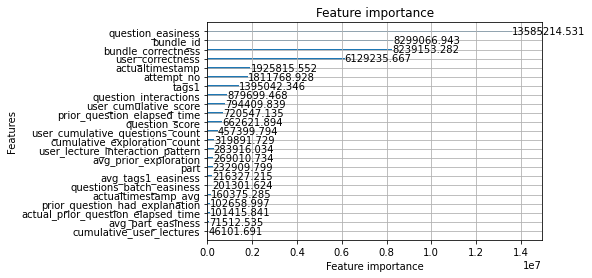

In [14]:
for i in range(0,num):
    # Create dataset object of lightgbm containing features and labels of train data instances
    train_data = lgb.Dataset(trains[i][features], label=trains[i][target])  
    # Create dataset object of lightgbm containing features and labels of validation data instances
    validation_data = lgb.Dataset(valids[i][features], label=valids[i][target]) 
    del trains
    del valids
    gc.collect()
    
# Build model and save it
#   model = lgb.train(
#         parameters, 
#         train_data,
#         num_boost_round=4000,
#         valid_sets=[train_data, validation_data],
#         early_stopping_rounds=40,
#         feature_name=features,
#         categorical_feature=categorical_columns,
#         verbose_eval=40
#   )
#   classifiers.append(model)
#pickle.dump(classifiers, open("classifiers.pkl", "wb"))

    # Load trained lightGBM model 
    classifiers_file = "lightgbm_modeling/classifiers.pkl"
    classifiers = pickle.load(open(classifiers_file, "rb"))
    # Plot level of importance for different features extracted while pre-processing
    lgb.plot_importance(classifiers[0], importance_type='gain')
    plt.show()
    del train_data
    del validation_data
    gc.collect()

# **Inferences**

In [15]:
from collections import defaultdict
# Get dictionaries of all features extracted from dataset
user_correctness_dict = user_level_calc['sum'].astype('int16').to_dict(defaultdict(int))
user_activeness_dict = user_level_calc['count'].astype('int16').to_dict(defaultdict(int))
question_score_dict = question_level_calc['sum'].astype('int32').to_dict(defaultdict(int))
question_interactions_dict = question_level_calc['count'].astype('int32').to_dict(defaultdict(int))
del user_level_calc
del question_level_calc
gc.collect()
questions_batch_score_dict = questions_batch_calc['sum'].astype('int32').to_dict(defaultdict(int))
questions_batch_count_dict = questions_batch_calc['count'].astype('int32').to_dict(defaultdict(int))
questions_batch_score_variance_dict = questions_batch_calc['var'].astype('float16').to_dict(defaultdict(int))
explanation_sum_dict = answer_explored_calc['sum'].astype('int16').to_dict(defaultdict(int))
explanation_count_dict = answer_explored_calc['count'].astype('int16').to_dict(defaultdict(int))
del questions_batch_calc
del answer_explored_calc
gc.collect()
user_lecture_sum_dict = user_lecture_aggregate['sum'].astype('int16').to_dict(defaultdict(int))
user_lecture_count_dict = user_lecture_aggregate['count'].astype('int16').to_dict(defaultdict(int))
actualtimestamp_avg_dict = actualtimestamp_calc['mean'].astype('int32').to_dict(defaultdict(int))
del user_lecture_aggregate
del actualtimestamp_calc
gc.collect()
interaction_total_attempts_calc=interaction_total_attempts_calc[interaction_total_attempts_calc['sum'] >1]
attempt_no_sum_dict = interaction_total_attempts_calc['sum'].to_dict(defaultdict(int))
del interaction_total_attempts_calc
gc.collect()
max_timestamp_u_dict=max_timestamp_u.set_index('user_id').to_dict()
user_prior_question_elapsed_time_dict=user_prior_question_elapsed_time.set_index('user_id').to_dict()
del max_timestamp_u
del user_prior_question_elapsed_time
gc.collect()


0

In [16]:
# Get maximum count of attempts for each question of user
def get_max_attempt(user_id,content_id): 
    k = (user_id,content_id)
    if k in attempt_no_sum_dict.keys():
        attempt_no_sum_dict[k]+=1
        return attempt_no_sum_dict[k]
    attempt_no_sum_dict[k] = 1
    return attempt_no_sum_dict[k]
print(psutil.virtual_memory().percent)

29.9


# **Self Attention Knowledge Tracing Model (Part 2)**

In [17]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Create class for feed-forward neural network
class FFN(nn.Module):
    
    # init() function defines architectural specifications of feed-forward neural network
    def __init__(self, state_size=200):
        super(FFN, self).__init__()
        self.state_size = state_size # Specifies number of features
        self.lr1 = nn.Linear(state_size, state_size) # First linear layer with 200 features in and 200 features out
        self.relu = nn.ReLU() # Rectified linear activation function
        self.lr2 = nn.Linear(state_size, state_size) # Second linear layer with 200 features in and 200 features out
        self.dropout = nn.Dropout(0.2) # Last dropout layer that drops number of nodes in a layer
    
    # forward() function defines functionality of feed-forward neural network
    def forward(self, x):
        x = self.lr1(x) 
        x = self.relu(x)
        x = self.lr2(x)
        return self.dropout(x)
    
def future_mask(seq_length):
    future_mask = np.triu(np.ones((seq_length, seq_length)), k=1).astype('bool')
    return torch.from_numpy(future_mask)

# Create class for self-attention knowledge tracing model
class SAKT_Model(nn.Module):
    
    # init() fuction defines architectural specifications of self-attention knowledge tracing model
    def __init__(self, n_quests, max_seq=MAX_SEQ, embed_dim=128): 
        super(SAKT_Model, self).__init__()
        self.n_quests = n_quests # Specifying number of vectors
        self.embed_dim = embed_dim # Specifying length of each vector
        self.embedding = nn.Embedding(2*n_quests+1, embed_dim) # Embeddings of vectors that are processed
        self.pos_embedding = nn.Embedding(max_seq-1, embed_dim) # Positional embeddings of vectors that track vectors ordering 
        self.e_embedding = nn.Embedding(n_quests+1, embed_dim) # Embeddings of vectors that pass as residual
       
        # Multiple heads indicate multiple vectors are processed simultaneously by self-attention mechanism
        self.multi_att = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=8, dropout=0.2)
        self.dropout = nn.Dropout(0.2)
        # In self-attention block, self-attention layer is followed by normalization layer
        self.layer_normal = nn.LayerNorm(embed_dim) 
        # Normalized output is fed to feed-forward neural network
        self.ffn = FFN(embed_dim)
        # Linear layer concatenates output of all heads to give a single output
        self.pred = nn.Linear(embed_dim, 1)
            
    # forward() function defines functionality of self-attention knowledge tracing model
    def forward(self, x, question_ids):
        device = x.device     
        # Get embeddings of x vector
        x = self.embedding(x)       
        pos_id = torch.arange(x.size(1)).unsqueeze(0).to(device)
        # Get positional embeddings of x vector
        pos_x = self.pos_embedding(pos_id)
        # Join both vector and positional embeddings
        x = x + pos_x
        # Get residual of vector embeddings
        e = self.e_embedding(question_ids)
        # Swap first two dimensions of tensors x and e
        x = x.permute(1, 0, 2) 
        e = e.permute(1, 0, 2)
        
        att_mask = future_mask(x.size(0)).to(device)
        # Self-attention layer is applied that outputs contextualized embeddings of vectors and their weight matrices
        att_output, att_weight = self.multi_att(e, x, x, attn_mask=att_mask)
        # Normalize the contextualized vector and residual vector
        att_output = self.layer_normal(att_output + e)
        # Swap first two dimensions of normalized output 
        att_output = att_output.permute(1, 0, 2) 
        # Input swapped-output to feed-forward neural network
        x = self.ffn(att_output)
        # Normalize the output of feed-forward neural network and residual of contexualized vector
        x = self.layer_normal(x + att_output)
        # Concatenate all contextualized vectors to a single vector
        x = self.pred(x)
        # Returns concatenated contextualized vector and weight matrix
        return x.squeeze(-1), att_weight

# Create class for test dataset
class TestDataset(Dataset):
    
    # init() function defines test data specifications
    def __init__(self, samples, test_df, quests, max_seq=MAX_SEQ): 
        super(TestDataset, self).__init__()
        self.samples = samples # Subset of test data
        self.user_ids = [x for x in test_df["user_id"].unique()] # List of user IDs in test data
        self.test_df = test_df # Entire test data
        self.quests = quests # List of user interactions
        self.n_quests = len(quests) # Count of user interactions
        self.max_seq = max_seq # Maximum count of user interactions

    # len() function provides rows count in test data
    def __len__(self):
        return self.test_df.shape[0]

    # getitem() function provides information about each item of test data 
    def __getitem__(self, index):
        # Get user_id and content_id of each test instance
        test_info = self.test_df.iloc[index]
        user_id = test_info["user_id"]
        target_id = test_info["content_id"]
        # If instance/user is found in samples then get his all interactions (q_) and score (qa_)
        q = np.zeros(self.max_seq, dtype=int)
        qa = np.zeros(self.max_seq, dtype=int)
        if user_id in self.samples.index:
            q_, qa_ = self.samples[user_id]
            # Check if interactions count (q_) is less than or equal to maximum interaction count (max_seq)        
            seq_len = len(q_)
            if seq_len >= self.max_seq:
                q = q_[-self.max_seq:]
                qa = qa_[-self.max_seq:]
            else:
                q[-seq_len:] = q_
                qa[-seq_len:] = qa_          
        # Make a copy of user interactions 
        x = np.zeros(self.max_seq-1, dtype=int)
        x = q[1:].copy()
        x += (qa[1:] == 1) * self.n_quests
        
        questions = np.append(q[2:], [target_id])
        
        return x, questions
# Device specification to run torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Build self-attention knowledge tracing model 
self_attention_knowledge_tracing_model = SAKT_Model(n_quests, embed_dim=128)
# Load tensor parameters for modeling of self-attention knowledge tracing
try:
    self_attention_knowledge_tracing_model.load_state_dict(torch.load("SAKT_modeling/SAKT-HDKIM.pt"))
except:
    self_attention_knowledge_tracing_model.load_state_dict(torch.load("SAKT_modeling/SAKT-HDKIM.pt", map_location='cpu'))
    
# Run model on device
self_attention_knowledge_tracing_model.to(device)
# Evaluate the model
self_attention_knowledge_tracing_model.eval()
# Load file "group_pkl"
group_file = "correctness_trend/group.pkl"
group = pickle.load(open(group_file, "rb"))
print(psutil.virtual_memory().percent)

34.9


# **Testing**

In [18]:
%%time
env = riiideducation.make_env()
iter_test = env.iter_test()
prior_test_df = None

for (test_df, sample_prediction_df) in iter_test:  
    if (prior_test_df is not None) & (psutil.virtual_memory().percent<90):
        # Evaluate label of test_df first instance
        prior_test_df[target] = eval(test_df['prior_group_answers_correct'].iloc[0])
        # Get prior_test_df containing data of question interactions only
        prior_test_df = prior_test_df[prior_test_df[target] != -1].reset_index(drop=True) 
        # Fill in NAN places of prior_test_df column "prior_question_had_explanation" with False
        prior_test_df['prior_question_had_explanation'].fillna(False, inplace=True)       
        prior_test_df.prior_question_had_explanation=prior_test_df.prior_question_had_explanation.astype('int8')
        # Get two consecutive lists of question ids and their respective scores for each user_id in prior_test_df
        prev_group = prior_test_df[['user_id', 'content_id', 'answered_correctly']].groupby('user_id').apply(lambda r: (
            r['content_id'].values,
            r['answered_correctly'].values))
        for prev_user_id in prev_group.index:
            prev_group_content = prev_group[prev_user_id][0] # Question id
            prev_group_ac = prev_group[prev_user_id][1] # Score
            # Get tuples of question_id and scores for each user_id of prev_group that is found in group 
            if prev_user_id in group.index:
                group[prev_user_id] = (np.append(group[prev_user_id][0],prev_group_content), 
                                       np.append(group[prev_user_id][1],prev_group_ac))
            else:
                group[prev_user_id] = (prev_group_content,prev_group_ac)
            # Check if questions count is less than or equal to MAX_SEQ=160
            if len(group[prev_user_id][0])>MAX_SEQ:
                new_group_content = group[prev_user_id][0][-MAX_SEQ:]
                new_group_ac = group[prev_user_id][1][-MAX_SEQ:]
                group[prev_user_id] = (new_group_content,new_group_ac)
        # Get values of some columns from "prior_test_df" to create their dictionaries  
        user_ids = prior_test_df['user_id'].values
        content_ids = prior_test_df['content_id'].values
        task_container_ids = prior_test_df['task_container_id'].values
        prior_question_had_explanations = prior_test_df['prior_question_had_explanation'].values
        targets = prior_test_df[target].values    
        for user_id, content_id,prior_question_had_explanation,task_container_id,answered_correctly in zip(user_ids, content_ids, prior_question_had_explanations,task_container_ids,targets):
            user_correctness_dict[user_id] += answered_correctly
            user_activeness_dict[user_id] += 1         
            explanation_sum_dict[user_id] += prior_question_had_explanation
            explanation_count_dict[user_id] += 1
            
    # Create a copy of test_df
    prior_test_df = test_df.copy()
    # Get test_df where interactions are only lectures
    lecture_test_df = test_df[test_df['content_type_id'] == 1].reset_index(drop=True)
    # Get total count of lectures interactions by each user_id
    for i, (user_id,content_type_id, content_id) in enumerate(zip(lecture_test_df['user_id'].values,lecture_test_df['content_type_id'].values,lecture_test_df['content_id'].values)):
        user_lecture_sum_dict[user_id] += content_type_id
        user_lecture_count_dict[user_id] += 1
        if(len(user_lecture_interactions[user_lecture_interactions.user_id==user_id])==0):
            user_lecture_interactions = user_lecture_interactions.append([{'user_id':user_id}], ignore_index=True)
            user_lecture_interactions.fillna(0, inplace=True)
            user_lecture_interactions.loc[user_lecture_interactions.user_id==user_id,lectures_top_categories + lectures_basic_purposes]+=lectures_df[lectures_df.lecture_id==content_id][lectures_top_categories + lectures_basic_purposes].values
        else:
            user_lecture_interactions.loc[user_lecture_interactions.user_id==user_id,lectures_top_categories + lectures_basic_purposes]+=lectures_df[lectures_df.lecture_id==content_id][lectures_top_categories + lectures_basic_purposes].values   
    # Get test_df where interactions are only questions
    test_df = test_df[test_df['content_type_id'] == 0].reset_index(drop=True)
    # Get test data and load its batch wise
    test_dataset = TestDataset(group, test_df, quests)
    test_dataloader = DataLoader(test_dataset, batch_size=51200, shuffle=False)
    
    self_attention_knowledge_tracing_outs = []
    # Get an instance from batch of test data
    for item in test_dataloader:
        x = item[0].to(device).long() # Features of test instance
        target_id = item[1].to(device).long() # Lable of test instance
        # Run self_attention_knowledge_tracing model to get prediction for given instance
        with torch.no_grad():
            output, att_weight = self_attention_knowledge_tracing_model(x, target_id)
        output = torch.sigmoid(output)
        output = output[:, -1]
        self_attention_knowledge_tracing_outs.extend(output.view(-1).data.cpu().numpy())
    # Fill NAN places in test_df column "prior_question_had_explanation" with False and "prior_question_elapsed_time" with its mean value
    test_df['prior_question_had_explanation'].fillna(False, inplace=True)
    test_df.prior_question_had_explanation=test_df.prior_question_had_explanation.astype('int8')
    test_df['prior_question_elapsed_time'].fillna(prior_question_elapsed_time_mean, inplace=True)
    # Initialization of variable arrays to get features
    user_lecture_sum = np.zeros(len(test_df), dtype=np.int16)
    user_lecture_count = np.zeros(len(test_df), dtype=np.int16)    
    user_sum = np.zeros(len(test_df), dtype=np.int16)
    user_count = np.zeros(len(test_df), dtype=np.int16)
    question_score = np.zeros(len(test_df), dtype=np.int32)
    question_interactions = np.zeros(len(test_df), dtype=np.int32)
    questions_batch_score = np.zeros(len(test_df), dtype=np.int32)
    questions_batch_count = np.zeros(len(test_df), dtype=np.int32)
    questions_batch_score_variance = np.zeros(len(test_df), dtype=np.float16)
    content_task_mean = np.zeros(len(test_df), dtype=np.float16)
    explanation_sum = np.zeros(len(test_df), dtype=np.int32)
    explanation_count = np.zeros(len(test_df), dtype=np.int32)
    actual_prior_question_elapsed_time = np.zeros(len(test_df), dtype=np.int32)
    attempt_no_count = np.zeros(len(test_df), dtype=np.int16)
    actualtimestamp = np.zeros(len(test_df), dtype=np.int32)
    actualtimestamp_avg = np.zeros(len(test_df), dtype=np.int32)  
    # Get features of each user from predefined dictionaries
    for i, (user_id,prior_question_had_explanation,content_type_id,prior_question_elapsed_time,timestamp, 
            content_id,task_container_id) in enumerate(zip(test_df['user_id'].values,
            test_df['prior_question_had_explanation'].values,test_df['content_type_id'].values,
            test_df['prior_question_elapsed_time'].values,test_df['timestamp'].values, test_df['content_id'].values,
            test_df['task_container_id'].values)):         
        user_lecture_sum_dict[user_id] += content_type_id
        user_lecture_count_dict[user_id] += 1        
        user_lecture_sum[i] = user_lecture_sum_dict[user_id]
        user_lecture_count[i] = user_lecture_count_dict[user_id]        
        user_sum[i] = user_correctness_dict[user_id]
        user_count[i] = user_activeness_dict[user_id]
        question_score[i] = question_score_dict[content_id]
        question_interactions[i] = question_interactions_dict[content_id]
        questions_batch_score[i] = questions_batch_score_dict[task_container_id]
        questions_batch_count[i] = questions_batch_count_dict[task_container_id]
        questions_batch_score_variance[i]=questions_batch_score_variance_dict[task_container_id]  
        explanation_sum[i] = explanation_sum_dict[user_id]
        explanation_count[i] = explanation_count_dict[user_id]
        # Get actualtimestamp by subtracting cumulative previous time from timestamp of an interaction
        if user_id in max_timestamp_u_dict['max_time_stamp'].keys():
            actualtimestamp[i]=timestamp-max_timestamp_u_dict['max_time_stamp'][user_id]
            max_timestamp_u_dict['max_time_stamp'][user_id]=timestamp
            actualtimestamp_avg[i]=(actualtimestamp_avg_dict[user_id]+actualtimestamp[i])/2           
        else:
            actualtimestamp[i]=0
            max_timestamp_u_dict['max_time_stamp'].update({user_id:timestamp})
            actualtimestamp_avg_dict.update({user_id:timestamp})
            actualtimestamp_avg[i]=(actualtimestamp_avg_dict[user_id]+actualtimestamp[i])/2
        # Get actual_prior_question_elapsed_time by subtracting cumulative previous time from prior_question_elapsed_time of an interaction
        if user_id in user_prior_question_elapsed_time_dict['prior_question_elapsed_time'].keys():            
            actual_prior_question_elapsed_time[i]=prior_question_elapsed_time-user_prior_question_elapsed_time_dict['prior_question_elapsed_time'][user_id]
            user_prior_question_elapsed_time_dict['prior_question_elapsed_time'][user_id]=prior_question_elapsed_time
        else:           
            actual_prior_question_elapsed_time[i]=0    
            user_prior_question_elapsed_time_dict['prior_question_elapsed_time'].update({user_id:prior_question_elapsed_time})
    # Merge test_df with questions_df based on "content_id" between two dataframes
    test_df=test_df.merge(questions_df.loc[questions_df.index.isin(test_df['content_id'])], how='left', on='content_id', right_index=True)
    # Define features added to test_df
    test_df['user_lecture_interaction_pattern'] = user_lecture_sum / user_lecture_count
    test_df['cumulative_user_lectures'] = user_lecture_sum
    test_df['user_correctness'] = user_sum / user_count
    test_df['user_cumulative_questions_count'] =user_count
    test_df['user_cumulative_score'] =user_sum
    test_df['question_easiness'] = question_score / question_interactions
    test_df['question_interactions'] = question_interactions
    test_df['question_score'] = question_score
    test_df['questions_batch_easiness'] = questions_batch_score / questions_batch_count
    test_df['questions_batch_score'] = questions_batch_score 
    test_df['questions_batch_score_variance'] = questions_batch_score_variance 
    test_df['avg_prior_exploration'] = explanation_sum / explanation_count
    test_df['cumulative_exploration_count'] = explanation_sum  
    test_df['actual_prior_question_elapsed_time'] = actual_prior_question_elapsed_time 
    test_df["attempt_no"] = test_df[["user_id", "content_id"]].apply(lambda row: get_max_attempt(row["user_id"], row["content_id"]), axis=1)
    test_df["actualtimestamp"]=actualtimestamp
    test_df["actualtimestamp_avg"]=actualtimestamp_avg
    # Fill NAN places of test_df columns "user_correctness" and "attempt_no" with 1 and in remaining columns with 0
    test_df['user_correctness'].fillna( 1, inplace=True)
    test_df['attempt_no'].fillna(1, inplace=True)
    test_df.fillna(0, inplace=True)
    # Convert values of timestamp from miliseconds to seconds 
    test_df['timestamp']=test_df['timestamp']/(1000*3600)
    test_df.timestamp=test_df.timestamp.astype('int16')
    # Get prediction score of each test_df instance (test_preds) that add up to get prediction score (sub_preds) for each classifier
    sub_preds = np.zeros(test_df.shape[0])
    for i, model in enumerate(classifiers, 1):
        test_preds  = model.predict(test_df[features])
        sub_preds += test_preds
    # Get average prediction for given "row_id"
    lightgbm_final = sub_preds / len(classifiers) 
    test_df[target] = np.array(self_attention_knowledge_tracing_outs) * 0.5 + lightgbm_final * 0.5  
    rows = test_df[target].to_csv()
    filename = "submission.csv"
    with open(filename, 'w') as csvfile: 
        csvwriter = csv.writer(csvfile)
        csvwriter.writerows(rows)        
    env.predict(test_df[['row_id', target]])


CPU times: user 1.19 s, sys: 162 ms, total: 1.36 s
Wall time: 1.61 s
